# Weather station wind data (LT and NRT)
Fernando Abárzuza | <fernando.abarzuza@gmail.com> | 3rd May 2024

This notebook explores the wind data from LT and NRT weather stations in order to identify significant differences between both datasets. For now, only data from the last 3 months (Feb 7th - now) has been analysed.

In [1]:
import pandas as pd
import scipy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
import pycircular

def standard_angle(angle: float) -> float:
    """
    Takes an angle in radians and returns it in the interval 0, 2*pi
    
    :param angle: Angle to be standardised, in radians.
    :return: An equivalent angle in the interval 0, 2*pi
    """
    if (angle > 2*np.pi) or (angle < 0):
        return angle%(2*np.pi)
    else:
        return angle

In [2]:
# Import LT weather data

data_path = "../data/meteo_lt.dat"
col_names = ["date", "wms_status", "rain_flag", "moisture_flag", "truss_temp", "oil_temp", "wind_speed", "wind_direction", "ambient_temp", "dew_point", "humidity", "air_pressure", "light"]
df1 = pd.read_csv(data_path, sep=" ", names = col_names, parse_dates=[0], date_format="%Y-%m-%d%H:%M:%SUTC")
df1["wind_direction_radians"] = df1["wind_direction"].apply(lambda x: standard_angle(np.radians(x)))
    

## Wind speed distribution

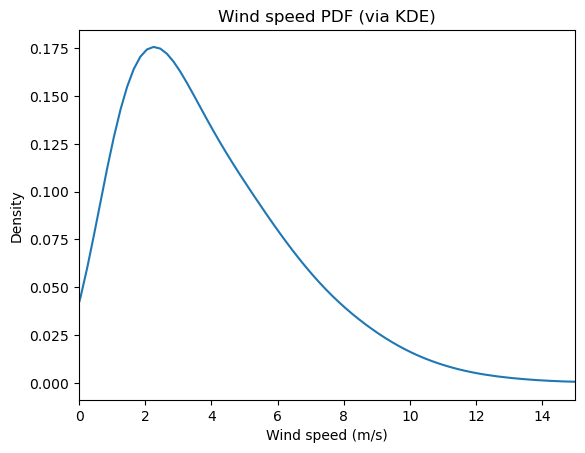

In [3]:
df1["wind_speed"].plot.kde(xlim=(0, 15), title="Wind speed PDF (via KDE)")
plt.xlabel(xlabel="Wind speed (m/s)")
plt.show()

## Wind direction distribution

A polar scatter plot can help us visualise the most frequent wind speed and directions.

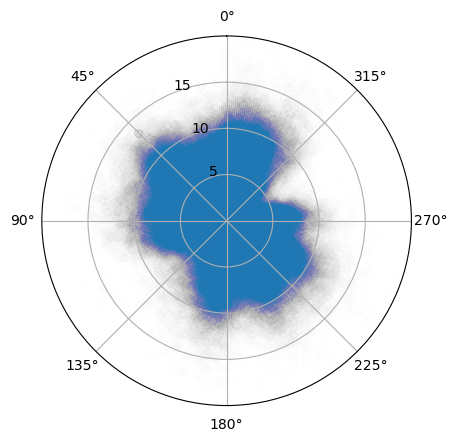

In [4]:
fig = plt.figure()
ax = fig.add_subplot(projection='polar')
c = ax.scatter(df1["wind_direction_radians"], df1["wind_speed"], alpha=0.005)
ax.set_rmax(20)
ax.set_rticks([5, 10, 15])
ax.set_theta_zero_location('N')

To get an idea of the density of the data, we can use a density estimator to approximate a continuous PDF, this is, a function $p$ such that $$\int_0^{2\pi} p(\theta) d\theta = 1$$ and $$\int_{\theta_1}^{\theta_2} p(\theta) d\theta$$ gives the probability of the wind direction being in the interval $[\theta_1, \theta_2]$.

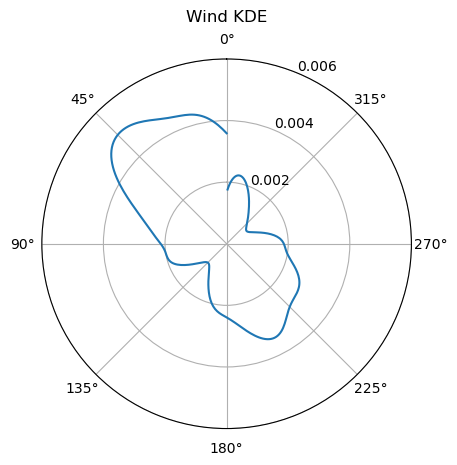

In [5]:
kde = scipy.stats.gaussian_kde(df1["wind_direction"])
theta = np.arange(0, 360, 1)
r = kde(theta)
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(theta/360*2*np.pi, r)
ax.set_rmax(0.006)
ax.set_rticks([0.002, 0.004, 0.006])  # Less radial ticks
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True)
ax.set_theta_zero_location('N')
ax.set_title("Wind KDE", va='bottom')
plt.show()

Linear KDE is not applicable because our data is angular and, therefore, modular (see the discontinuity of the KDE at $\theta = 0\;\text{deg}$). There aren't many tools designed to do KDE analysis on circular data. We try the `pycircular` package.

We first select a sample to calculate the bandwith.

In [6]:
wind_sample = df1["wind_direction_radians"].sample(n=2000).tolist()
wind_sample
bw = pycircular.circular.bwEstimation(wind_sample)
print("Suggested bandwidth:",bw)

Suggested bandwidth: 108.24422542377579


In [7]:
circular_kde = pycircular.circular.kernel(df1["wind_direction_radians"], bw=bw, n=256)

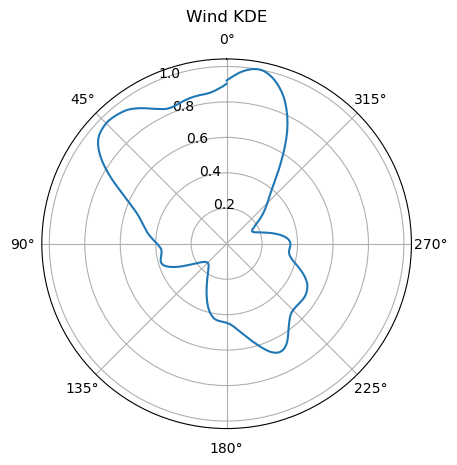

In [8]:
x = np.linspace(0, 2*np.pi, 256)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.set_theta_zero_location('N')
ax.set_title("Wind KDE", va='bottom')
ax.plot(x, circular_kde)
plt.show()

https://gist.github.com/jobovy/a10a97353b8200b397de1f35a6525ece

# NRT Weather data

**Connector doesn't work**. In contact with Joao to get the right credentials.

In [ ]:
from influxdb import InfluxDBClient

host = 'influxdb.services.newrobotictelescope.org'
port = 8086
username = 'nrt-admin'
password = 'super_secret_password'
ssl = True
verify_ssl = True

client = InfluxDBClient(host=host, port=port, username=username, password=password, ssl=ssl, verify_ssl=verify_ssl)
client.get_list_database()

Temporary solution: download the data and load it locally.

In [10]:
data_path = "../data/2024-05-03_13_51_influxdb_data.csv"
col_names = ["start_date", "end_date", "date", "value", "field", "measurement", "device", "site", "source", "subsystem"]


with open(data_path) as file:
    filedata = file.read()

# Ignore the first columns of data    
filedata = filedata.replace(",,0,", "")
filedata = filedata.replace(",,1,", "")


# Save data again
with open(data_path, "w") as file:
    file.write(filedata)
    
# Import file in pandas
df2 = pd.read_csv(data_path, sep=",", names = col_names, skiprows=4)

# Drop rows in which the date is longer than 20 characters
# For some reason Infux outputs the last measurement with more precision than the other measurements
df2 = df2[df2["date"].str.len() <= 20]

# Extract wind speed and direction in different dataframes and convert date to datetime
df2_direction = df2[df2["field"] == "wind_direction_avg"]
df2_direction = df2_direction[["date", "value"]]
df2_direction["date"] = pd.to_datetime(df2_direction["date"], format="%Y-%m-%dT%H:%M:%SZ")

df2_speed = df2[df2["field"] == "wind_speed_avg"]
df2_speed = df2_speed[["date", "value"]]
df2_speed["date"] = pd.to_datetime(df2_speed["date"], format="%Y-%m-%dT%H:%M:%SZ")

# Merge both dataframes on date
df2 = pd.merge(df2_speed, df2_direction, on="date", suffixes=("_speed", "_direction"))

# Change the name of the columns to make it consistent with the LT data
df2 = df2.rename(columns={"date": "date", "value_speed": "wind_speed", "value_direction": "wind_direction"})

# Convert wind direction to radians
df2["wind_direction_radians"] = df2["wind_direction"].apply(lambda x: standard_angle(np.radians(x)))

We can now perform the same plots as with the LT weather data. First, however, from the LT data, we need to select the same time period as the NRT data, starting from February 7th 2024.

In [11]:
df1_restricted = df1[df1["date"] >= "2024-02-07"]

## Wind speed distribution comparison

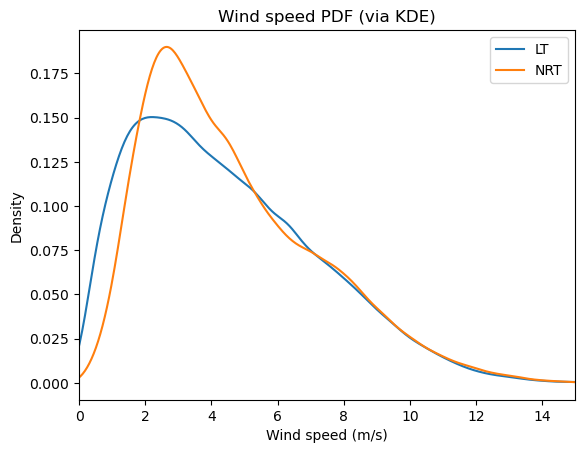

In [12]:
df1_restricted["wind_speed"].plot.kde(xlim=(0, 15), title="Wind speed PDF (via KDE)")
df2["wind_speed"].plot.kde(xlim=(0, 15), title="Wind speed PDF (via KDE)")
plt.xlabel(xlabel="Wind speed (m/s)")
plt.legend(["LT", "NRT"])

## Wind direction distribution comparison

In [ ]:
wind_sample = df2["wind_direction_radians"].sample(n=2000).tolist()
wind_sample
bw = pycircular.circular.bwEstimation(wind_sample)
print("Suggested bandwidth:",bw)

In [ ]:
circular_kde1 = pycircular.circular.kernel(df1_restricted["wind_direction_radians"].tolist(), bw=bw, n=256)
circular_kde2 = pycircular.circular.kernel(df2["wind_direction_radians"].tolist(), bw=bw, n=256)

In [ ]:
x = np.linspace(0, 2*np.pi, 256)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.set_theta_zero_location('N')
ax.set_title("Wind KDE", va='bottom')
ax.plot(x, circular_kde1)
ax.plot(x, circular_kde2)
plt.show()

In [72]:
max_index1 = np.argmax(circular_kde1)
max_index2 = np.argmax(circular_kde2)
print("Mode angle at KDE1 (LT):", x[max_index1], "(", np.degrees(x[max_index1]), "deg)")
print("Mode angle at KDE2 (NRT):", x[max_index2], "(", np.degrees(x[max_index2]), "deg)")

Mode angle at KDE1 (LT): 0.6899183866706997 ( 39.529411764705884 deg)
Mode angle at KDE2 (NRT): 5.987505998606429 ( 343.05882352941177 deg)


## Questions and next steps
* It appears that there are significant differnces in the wind distribution, particularly in the direction. LT has a predominantly N-W wind, at 340 degrees. NRT has a predominantly northern wind, with the most likely direction at 40 degrees.
* Wind speed is more similar. LT data shows more frequent windspeeds under 2 m/s. NRT data has a higher frequency of winds in the 2-5 m/s range. However, after 5m/s, the wind distribution is very similar.
* This data is, however, restricted to the last 3 months. It would be interesting to see if these differences are consistent throughout the year. Legacy weather data from NRT has to be analysed.
* It would also be interesting to evaluate the peak in wind speeds (wind gusts), as they can dramatically affect the telescope operation. NRT weather station has a min/max record, but LT does not record this information.
